Setup for the KSQL API:

In [1]:
from ksql import KSQLAPI
client = KSQLAPI('http://localhost:8088')

In [4]:
client.create_stream(table_name='creditcardfraud_source',
                     columns_type=['Id bigint', 'Time int', 'V1 double', 'V2 double', 'V3 double', 'V4 double', 'V5 double', 'V6 double', 'V7 double', 'V8 double', 'V9 double', 'V10 double', 'V11 double', 'V12 double', 'V13 double', 'V14 double', 'V15 double', 'V16 double', 'V17 double', 'V18 double', 'V19 double', 'V20 double', 'V21 double', 'V22 double', 'V23 double', 'V24 double', 'V25 double', 'V26 double', 'V27 double', 'V28 double', 'Amount double', 'Class string'],
                     topic='creditcardfraud_source',
                     value_format='DELIMITED')

KSQLError: ('Topic already registered: CREDITCARDFRAUD_SOURCE', 40001, ['io.confluent.ksql.ddl.commands.RegisterTopicCommand.run(RegisterTopicCommand.java:96)', 'io.confluent.ksql.ddl.commands.CreateStreamCommand.run(CreateStreamCommand.java:41)', 'io.confluent.ksql.ddl.commands.DdlCommandExec.executeOnMetaStore(DdlCommandExec.java:60)', 'io.confluent.ksql.ddl.commands.DdlCommandExec.tryExecute(DdlCommandExec.java:44)', 'io.confluent.ksql.KsqlEngine.postProcessSingleDdlStatement(KsqlEngine.java:429)', 'io.confluent.ksql.KsqlEngine.postProcessSingleQueryAst(KsqlEngine.java:342)', 'io.confluent.ksql.KsqlEngine.lambda$parseStatements$2(KsqlEngine.java:301)', 'java.util.stream.ReferencePipeline$3$1.accept(ReferencePipeline.java:193)', 'java.util.stream.ReferencePipeline$3$1.accept(ReferencePipeline.java:193)', 'java.util.stream.ReferencePipeline$2$1.accept(ReferencePipeline.java:175)', 'java.util.ArrayList$ArrayListSpliterator.forEachRemaining(ArrayList.java:1374)', 'java.util.stream.AbstractPipeline.copyInto(AbstractPipeline.java:481)', 'java.util.stream.AbstractPipeline.wrapAndCopyInto(AbstractPipeline.java:471)', 'java.util.stream.ReduceOps$ReduceOp.evaluateSequential(ReduceOps.java:708)', 'java.util.stream.AbstractPipeline.evaluate(AbstractPipeline.java:234)', 'java.util.stream.ReferencePipeline.collect(ReferencePipeline.java:499)', 'io.confluent.ksql.parser.KsqlParser.buildAst(KsqlParser.java:106)', 'io.confluent.ksql.parser.KsqlParser.buildAst(KsqlParser.java:92)', 'io.confluent.ksql.KsqlEngine.parseStatements(KsqlEngine.java:298)', 'io.confluent.ksql.KsqlEngine.parseStatements(KsqlEngine.java:285)', 'io.confluent.ksql.rest.server.resources.KsqlResource.handleKsqlStatements(KsqlResource.java:167)', 'sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)', 'sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)', 'sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)', 'java.lang.reflect.Method.invoke(Method.java:498)', 'org.glassfish.jersey.server.model.internal.ResourceMethodInvocationHandlerFactory.lambda$static$0(ResourceMethodInvocationHandlerFactory.java:76)', 'org.glassfish.jersey.server.model.internal.AbstractJavaResourceMethodDispatcher$1.run(AbstractJavaResourceMethodDispatcher.java:148)', 'org.glassfish.jersey.server.model.internal.AbstractJavaResourceMethodDispatcher.invoke(AbstractJavaResourceMethodDispatcher.java:191)', 'org.glassfish.jersey.server.model.internal.JavaResourceMethodDispatcherProvider$ResponseOutInvoker.doDispatch(JavaResourceMethodDispatcherProvider.java:200)', 'org.glassfish.jersey.server.model.internal.AbstractJavaResourceMethodDispatcher.dispatch(AbstractJavaResourceMethodDispatcher.java:103)', 'org.glassfish.jersey.server.model.ResourceMethodInvoker.invoke(ResourceMethodInvoker.java:493)', 'org.glassfish.jersey.server.model.ResourceMethodInvoker.apply(ResourceMethodInvoker.java:415)', 'org.glassfish.jersey.server.model.ResourceMethodInvoker.apply(ResourceMethodInvoker.java:104)', 'org.glassfish.jersey.server.ServerRuntime$1.run(ServerRuntime.java:277)', 'org.glassfish.jersey.internal.Errors$1.call(Errors.java:272)', 'org.glassfish.jersey.internal.Errors$1.call(Errors.java:268)', 'org.glassfish.jersey.internal.Errors.process(Errors.java:316)', 'org.glassfish.jersey.internal.Errors.process(Errors.java:298)', 'org.glassfish.jersey.internal.Errors.process(Errors.java:268)', 'org.glassfish.jersey.process.internal.RequestScope.runInScope(RequestScope.java:289)', 'org.glassfish.jersey.server.ServerRuntime.process(ServerRuntime.java:256)', 'org.glassfish.jersey.server.ApplicationHandler.handle(ApplicationHandler.java:703)', 'org.glassfish.jersey.servlet.WebComponent.serviceImpl(WebComponent.java:416)', 'org.glassfish.jersey.servlet.ServletContainer.serviceImpl(ServletContainer.java:409)', 'org.glassfish.jersey.servlet.ServletContainer.doFilter(ServletContainer.java:584)', 'org.glassfish.jersey.servlet.ServletContainer.doFilter(ServletContainer.java:525)', 'org.glassfish.jersey.servlet.ServletContainer.doFilter(ServletContainer.java:462)', 'org.eclipse.jetty.servlet.ServletHandler$CachedChain.doFilter(ServletHandler.java:1642)', 'org.eclipse.jetty.servlet.ServletHandler.doHandle(ServletHandler.java:533)', 'org.eclipse.jetty.server.handler.ScopedHandler.nextHandle(ScopedHandler.java:255)', 'org.eclipse.jetty.server.session.SessionHandler.doHandle(SessionHandler.java:1595)', 'org.eclipse.jetty.server.handler.ScopedHandler.nextHandle(ScopedHandler.java:255)', 'org.eclipse.jetty.server.handler.ContextHandler.doHandle(ContextHandler.java:1340)', 'org.eclipse.jetty.server.handler.ScopedHandler.nextScope(ScopedHandler.java:203)', 'org.eclipse.jetty.servlet.ServletHandler.doScope(ServletHandler.java:473)', 'org.eclipse.jetty.server.session.SessionHandler.doScope(SessionHandler.java:1564)', 'org.eclipse.jetty.server.handler.ScopedHandler.nextScope(ScopedHandler.java:201)', 'org.eclipse.jetty.server.handler.ContextHandler.doScope(ContextHandler.java:1242)', 'org.eclipse.jetty.server.handler.ScopedHandler.handle(ScopedHandler.java:144)', 'org.eclipse.jetty.server.handler.HandlerCollection.handle(HandlerCollection.java:126)', 'org.eclipse.jetty.server.handler.StatisticsHandler.handle(StatisticsHandler.java:174)', 'org.eclipse.jetty.server.handler.ContextHandlerCollection.handle(ContextHandlerCollection.java:220)', 'org.eclipse.jetty.server.handler.gzip.GzipHandler.handle(GzipHandler.java:740)', 'org.eclipse.jetty.server.handler.HandlerWrapper.handle(HandlerWrapper.java:132)', 'org.eclipse.jetty.server.Server.handle(Server.java:503)', 'org.eclipse.jetty.server.HttpChannel.handle(HttpChannel.java:364)', 'org.eclipse.jetty.server.HttpConnection.onFillable(HttpConnection.java:260)', 'org.eclipse.jetty.io.AbstractConnection$ReadCallback.succeeded(AbstractConnection.java:305)', 'org.eclipse.jetty.io.FillInterest.fillable(FillInterest.java:103)', 'org.eclipse.jetty.io.ChannelEndPoint$2.run(ChannelEndPoint.java:118)', 'org.eclipse.jetty.util.thread.strategy.EatWhatYouKill.runTask(EatWhatYouKill.java:333)', 'org.eclipse.jetty.util.thread.strategy.EatWhatYouKill.doProduce(EatWhatYouKill.java:310)', 'org.eclipse.jetty.util.thread.strategy.EatWhatYouKill.tryProduce(EatWhatYouKill.java:168)', 'org.eclipse.jetty.util.thread.strategy.EatWhatYouKill.run(EatWhatYouKill.java:126)', 'org.eclipse.jetty.util.thread.ReservedThreadExecutor$ReservedThread.run(ReservedThreadExecutor.java:366)', 'org.eclipse.jetty.util.thread.QueuedThreadPool.runJob(QueuedThreadPool.java:765)', 'org.eclipse.jetty.util.thread.QueuedThreadPool$2.run(QueuedThreadPool.java:683)', 'java.lang.Thread.run(Thread.java:745)'])

In [5]:
client.ksql('show streams')

[{'@type': 'streams',
  'statementText': 'show streams;',
  'streams': [{'type': 'STREAM',
    'name': 'CREDITCARDFRAUD_PREPROCESSED',
    'topic': 'creditcardfraud_preprocessed',
    'format': 'AVRO'},
   {'type': 'STREAM',
    'name': 'CREDITCARDFRAUD_SOURCE',
    'topic': 'creditcardfraud_source',
    'format': 'DELIMITED'}]}]

Execute sql query and keep listening streaming data:

In [ ]:
# TODO How to embed ' ' in Python ???
# client.ksql('SET 'auto.offset.reset'='earliest'');

In [28]:
a = "Kai"
print("BEFORE " + a)
query = client.query('select * from creditcardfraud_source LIMIT 1')

for item in query: 
    print(item)
    a = item
    print(type(a))
    print("AFTER " + a)

BEFORE Kai


{"row":{"columns":[1545584003706,null,1,"2018-12-18T12:00:00Z","Kai",0,-1.3598071336738,-0.0727811733098497,2.53634673796914
<class 'str'>
AFTER 

{"row":{"columns":[1545584003706,null,1,"2018-12-18T12:00:00Z","Kai",0,-1.3598071336738,-0.0727811733098497,2.53634673796914
,1.37815522427443,-0.338320769942518,0.462387777762292,0.239598554061257,0.0986979012610507,0.363786969611213,0.0907941719789316,-0.551599533260813,-0.617800855762348,-0.991389847235408,-0.311169353699879,1.46817697209427,-0.470400525259478,0.207971241929242,0.0257905801
<class 'str'>
AFTER ,1.37815522427443,-0.338320769942518,0.462387777762292,0.239598554061257,0.0986979012610507,0.363786969611213,0.0907941719789316,-0.551599533260813,-0.617800855762348,-0.991389847235408,-0.311169353699879,1.46817697209427,-0.470400525259478,0.207971241929242,0.0257905801
985591,0.403992960255733,0.251412098239705,-0.018306777944153,0.277837575558899,-0.110473910188767,0.0669280749146731,0.128539358273528,-0.189114843888

This above command returns a generator. It can be printed e.g. by reading its values via next(query) or a for loop.

TODO Get KSQL list into correct Python structure (list? dict?) for Numpy and TensorFlow

https://towardsdatascience.com/23-great-pandas-codes-for-data-scientists-cca5ed9d8a38
https://pandas.pydata.org/pandas-docs/stable/10min.html
https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.iterrows.html

In [32]:
query

<generator object BaseAPI.query at 0x11b0c1728>

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

/Users/kai.waehner/anaconda/envs/ksql-python/lib/python3.6/site-packages/matplotlib/font_manager.py:232: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [30]:
print(a)

null,"errorMessage":null,"finalMessage":"Limit Reached"}



In [13]:
dataframe = pd.DataFrame(query)

In [14]:
print(dataframe)

Empty DataFrame
Columns: []
Index: []


# Pandas analysis with above Fraud Detection Data

In [41]:
df = pd.read_csv("data/creditcard.csv")

In [42]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [43]:
df.shape

(284807, 31)

In [45]:
df.index

RangeIndex(start=0, stop=284807, step=1)

In [46]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [47]:
df.values

array([[ 0.00000000e+00, -1.35980713e+00, -7.27811733e-02, ...,
        -2.10530535e-02,  1.49620000e+02,  0.00000000e+00],
       [ 0.00000000e+00,  1.19185711e+00,  2.66150712e-01, ...,
         1.47241692e-02,  2.69000000e+00,  0.00000000e+00],
       [ 1.00000000e+00, -1.35835406e+00, -1.34016307e+00, ...,
        -5.97518406e-02,  3.78660000e+02,  0.00000000e+00],
       ...,
       [ 1.72788000e+05,  1.91956501e+00, -3.01253846e-01, ...,
        -2.65608286e-02,  6.78800000e+01,  0.00000000e+00],
       [ 1.72788000e+05, -2.40440050e-01,  5.30482513e-01, ...,
         1.04532821e-01,  1.00000000e+01,  0.00000000e+00],
       [ 1.72792000e+05, -5.33412522e-01, -1.89733337e-01, ...,
         1.36489143e-02,  2.17000000e+02,  0.00000000e+00]])

In [48]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.490107e-15,-5.556467e-16,1.177556e-16,-2.406455e-15,...,1.656562e-16,-3.444850e-16,2.578648e-16,4.471968e-15,5.340915e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [50]:
df['Amount']

0         149.62
1           2.69
2         378.66
3         123.50
4          69.99
5           3.67
6           4.99
7          40.80
8          93.20
9           3.68
10          7.80
11          9.99
12        121.50
13         27.50
14         58.80
15         15.99
16         12.99
17          0.89
18         46.80
19          5.00
20        231.71
21         34.09
22          2.28
23         22.75
24          0.89
25         26.43
26         41.88
27         16.00
28         33.00
29         12.99
           ...  
284777      1.00
284778     80.00
284779     25.00
284780     30.00
284781     13.00
284782     12.82
284783     11.46
284784     40.00
284785      1.79
284786      8.95
284787      9.99
284788      3.99
284789     60.50
284790      9.81
284791     20.32
284792      3.99
284793      4.99
284794      0.89
284795      9.87
284796     60.00
284797      5.49
284798     24.05
284799     79.99
284800      2.68
284801      2.69
284802      0.77
284803     24.79
284804     67.

In [51]:
df[0:3]

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [52]:
df.iloc[1,1]

1.1918571113148602

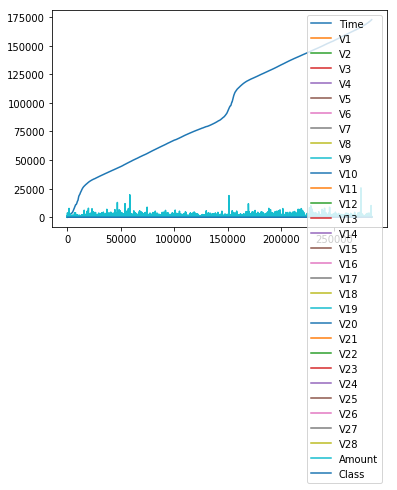

In [55]:
# Takes a minute or two (big CSV file)...
#df.plot()